In [84]:
import scanpy as sc
import scvi

In [85]:
adata = sc.read_h5ad("1_qc.h5ad")
adata = adata[~adata.obs["is_rr"]]
sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key="sample", layer="log1p")

/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [86]:
umap_colorings = [
    "sample",
    "cell_type",
]

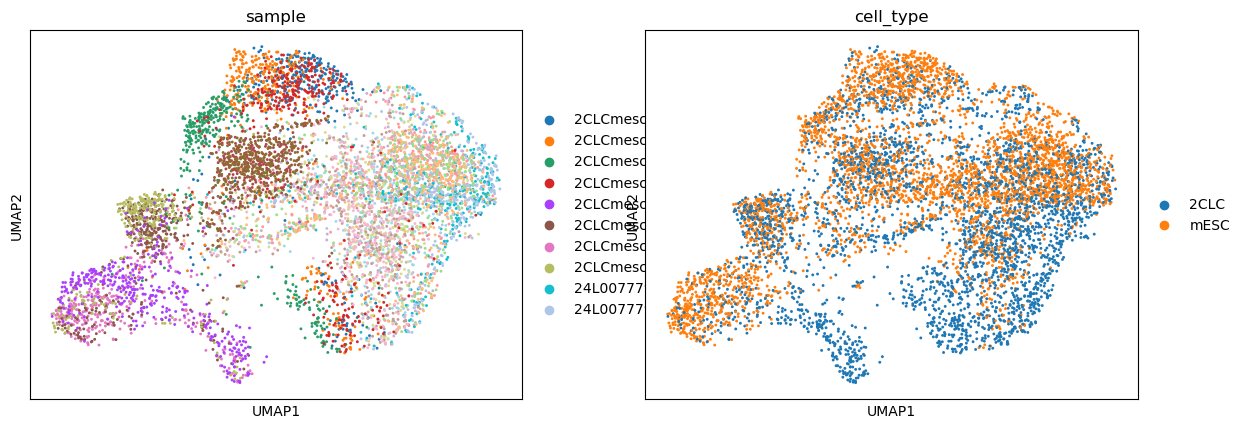

In [87]:
sc.pp.pca(adata, n_comps=50, layer="log1p")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=umap_colorings,
)

In [88]:
adata_hvg = adata[:, adata.var.highly_variable].copy()

In [89]:
scvi.model.SCVI.setup_anndata(adata_hvg, batch_key="sample", layer="counts")
model = scvi.model.SCVI(adata_hvg)

In [90]:
model.train(max_epochs=200, accelerator='cuda')

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/nfs/home/students/n.trummer/.conda/envs/sc-gpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on

Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [91]:
adata.obsm["X_scvi"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")

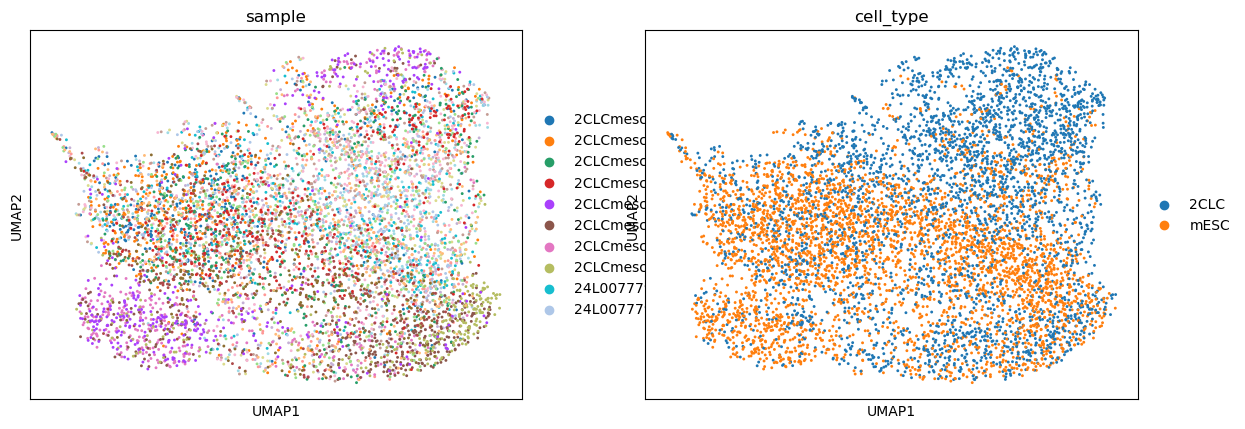

In [92]:
sc.tl.umap(adata)
adata.obsm["X_umap_scvi"] = adata.obsm["X_umap"]
sc.pl.umap(
    adata,
    color=umap_colorings,
)

In [93]:
sc.external.pp.harmony_integrate(adata, "sample", max_iter_harmony=20)

2025-01-02 20:15:29,128 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-02 20:15:29,805 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-02 20:15:29,830 - harmonypy - INFO - Iteration 1 of 20
2025-01-02 20:15:31,828 - harmonypy - INFO - Iteration 2 of 20
2025-01-02 20:15:33,712 - harmonypy - INFO - Iteration 3 of 20
2025-01-02 20:15:35,590 - harmonypy - INFO - Iteration 4 of 20
2025-01-02 20:15:37,207 - harmonypy - INFO - Iteration 5 of 20
2025-01-02 20:15:39,212 - harmonypy - INFO - Iteration 6 of 20
2025-01-02 20:15:40,310 - harmonypy - INFO - Iteration 7 of 20
2025-01-02 20:15:41,598 - harmonypy - INFO - Iteration 8 of 20
2025-01-02 20:15:42,895 - harmonypy - INFO - Iteration 9 of 20
2025-01-02 20:15:43,972 - harmonypy - INFO - Iteration 10 of 20
2025-01-02 20:15:45,082 - harmonypy - INFO - Iteration 11 of 20
2025-01-02 20:15:46,166 - harmonypy - INFO - Iteration 12 of 20
2025-01-02 20:15:47,632 - harmonypy - INFO - Iteration 13 of

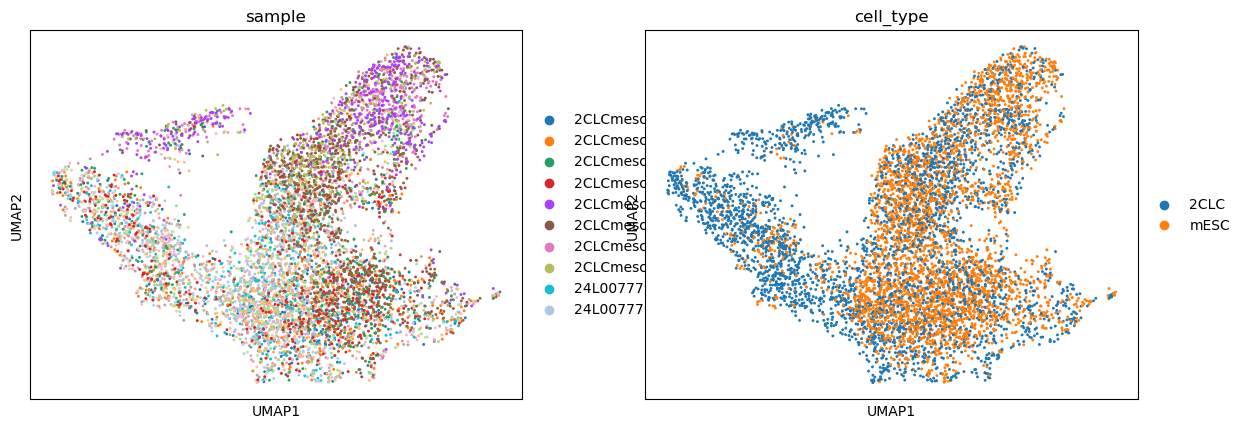

In [94]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony")
sc.tl.umap(adata)
adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"]
sc.pl.umap(
    adata,
    color=umap_colorings
)

In [95]:
adata

AnnData object with n_obs × n_vars = 6966 × 27521
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_scvi', 'X_umap_scvi', 'X_pca_harmony', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances',

In [96]:
adata.write("2_integrate.h5ad")